# Installations

In [1]:
pip install ir_datasets

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.4 MB/s eta 0:00:00
  Created wheel for warc3-wet-clueweb09: filename=warc3_wet_clueweb09-0.2.5-py3-none-any.whl size=18920 sha256=ca4af98cf1e2c4d3e4d5710a8e75c95cf53101c84f1006ce7ddbd83c46e83e47
  Stored in directory: /root/.cache/pip/wheels/1a/d7/91/7ffb991df87e62355d945745035470ba2616aa3d83a250b5f9
  Created wheel for cbor: filename=cbor-1.0.0-cp310-cp310-linux_x86_64.whl size=53430 sha256=6a4acc8dfb4b48bdeb78e811b3797319dd0bf7f5c48831c65dd37bd865ea6890
  Stored in directory: /root/.cache/pip/wheels/85/df/c9/b39e40eccaf76dbd218556639a6dc81562226f4c6a64902c85
Successfully built warc3-wet-clueweb09 cbor


In [2]:
pip install ir_measures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 8.4 MB/s eta 0:00:00


# Imports

In [3]:
import torch
import ir_datasets
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.spatial.distance import cdist
from sentence_transformers import util
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from ir_measures import nDCG, MAP, Recall, calc_aggregate
from ir_measures import ScoredDoc

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Dataset

In [4]:
dataset = ir_datasets.load("neuclir/1/ru/trec-2023")
dataset

Dataset(id='neuclir/1/ru/trec-2023', provides=['docs', 'queries', 'qrels'])

In [6]:
russian_documents = [(doc.doc_id, doc.text) for doc in dataset.docs_iter()]
qrels = [(qrel.query_id, qrel.doc_id, qrel.relevance) for qrel in dataset.qrels_iter()]

[INFO] If you have a local copy of https://huggingface.co/datasets/neuclir/neuclir1/resolve/main/data/rus-00000-of-00001.jsonl.gz?download=true, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/3aabc798a3b5dd92d7c47db9521870b1
[INFO] [starting] https://huggingface.co/datasets/neuclir/neuclir1/resolve/main/data/rus-00000-of-00001.jsonl.gz?download=true
[INFO] [finished] https://huggingface.co/datasets/neuclir/neuclir1/resolve/main/data/rus-00000-of-00001.jsonl.gz?download=true: [01:31] [4.50GB] [49.3MB/s]
[INFO] If you have a local copy of https://trec.nist.gov/data/neuclir/2023/neuclir-2023-qrels.final.tar.gz, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/cea4ff3d9eba612c7119e6490217d4e1
[INFO] [starting] https://trec.nist.gov/data/neuclir/2023/neuclir-2023-qrels.final.tar.gz
[INFO] [finished] https://trec.nist.gov/data/neuclir/2023/neuclir-2023-qrels.final.tar.gz: [00:00] [6.02MB] [43.7MB/s]


In [7]:
# we sample the documents which are mentioned in qrels
qrels_ids = {entry[1] for entry in tqdm(qrels)}
russian_documents_subset = [doc for doc in tqdm(russian_documents) if doc[0] in qrels_ids]
len(russian_documents_subset)

100%|██████████| 4627543/4627543 [00:01<00:00, 3245041.84it/s]


24871

In [8]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
content = [doc[1] for doc in russian_documents_subset]  # Extract titles from the documents
content_embeddings = model.encode(
    content,
    batch_size=512,  # Test larger values like 512 or 1024
    convert_to_tensor=True,
    show_progress_bar=True
)

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
torch.save(content_embeddings, 'title_embeddings.pt')

In [12]:
english_queries = [(query.query_id, query.title) for query in dataset.queries_iter()]

In [18]:
query_embeddings = torch.load('query_embeddings.pt')

<ipython-input-18-3c57c2cb19c3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  query_embeddings = torch.load('query_embeddings.pt')


# Functions

In [19]:
def rbp(retrieved_results, qrels, p=0.8):
    from collections import defaultdict
    qrels_dict = defaultdict(set)

    # Process qrels into a dictionary
    for qrel in qrels:
        query_id = qrel.query_id
        doc_id = qrel.doc_id
        relevance = qrel.relevance
        if relevance > 0:  # Only consider relevant documents (rel >= 1)
            qrels_dict[query_id].add(doc_id)

    rbp_scores = {}
    for query_id, retrieved_docs in retrieved_results.items():
        score = 0
        for rank, (doc_id, _) in enumerate(retrieved_docs, start=1):
            if doc_id in qrels_dict.get(query_id, set()):
                score += (1 - p) * (p ** (rank - 1))
        rbp_scores[query_id] = score

    return rbp_scores


# Training

In [20]:
from ir_measures import Qrel

# Convert qrels to Qrel objects
qrels_ir = [Qrel(query_id=qrel.query_id, doc_id=qrel.doc_id, relevance=qrel.relevance) for qrel in dataset.qrels_iter()]
# Define the number of top documents to retrieve
top_k = 1000

In [21]:
# Initialize a dictionary to store the top-k results for each query
cosine_retrieved_results = {}

cosine_results = []
for query_idx, query_embedding in enumerate(query_embeddings):
    # Compute cosine similarities between this query and all document embeddings
    similarities = util.cos_sim(query_embedding, content_embeddings)[0]

    # Get the top-k most similar documents
    top_k_scores, top_k_indices = torch.topk(similarities, k=top_k)

    # Collect results for this query
    query_id = english_queries[query_idx][0]  # Assuming the first element is query_id
    cosine_results.extend([
        ScoredDoc(query_id=query_id, doc_id=russian_documents_subset[doc_idx][0], score=top_k_scores[i].item())
        for i, doc_idx in enumerate(top_k_indices)
    ])

In [22]:
# Initialize a dictionary to store the top-k results for each query
dot_product_results = []

for query_idx, query_embedding in enumerate(query_embeddings):
    # Compute dot product similarities between this query and all document embeddings
    similarities = torch.matmul(content_embeddings, query_embedding.T).squeeze()  # Shape: (num_documents,)

    # Get the top-k most similar documents
    actual_top_k = min(top_k, similarities.size(0))  # Adjust top_k to avoid out-of-range errors
    top_k_scores, top_k_indices = torch.topk(similarities, k=actual_top_k)

    # Collect results for this query
    query_id = english_queries[query_idx][0]  # Assuming the first element is query_id
    dot_product_results.extend([
        ScoredDoc(query_id=query_id, doc_id=russian_documents_subset[doc_idx][0], score=top_k_scores[i].item())
        for i, doc_idx in enumerate(top_k_indices)
    ])

<ipython-input-22-c5a87dc0a04b>:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  similarities = torch.matmul(content_embeddings, query_embedding.T).squeeze()  # Shape: (num_documents,)


In [23]:
# Initialize a list to store the top-k results for each query
euclidean_results = []

for query_idx, query_embedding in enumerate(query_embeddings):
    # Compute Euclidean distance between this query and all document embeddings
    distances = torch.norm(content_embeddings - query_embedding, dim=1)  # Shape: (num_documents,)

    # Invert the distance to treat it as a similarity score (higher is better)
    similarities = -distances  # Use negative distances for ranking

    # Get the top-k most similar documents
    actual_top_k = min(top_k, similarities.size(0))  # Adjust top_k to avoid out-of-range errors
    top_k_scores, top_k_indices = torch.topk(similarities, k=actual_top_k)

    # Collect results for this query
    query_id = english_queries[query_idx][0]  # Assuming the first element is query_id
    euclidean_results.extend([
        ScoredDoc(query_id=query_id, doc_id=russian_documents_subset[doc_idx][0], score=top_k_scores[i].item())
        for i, doc_idx in enumerate(top_k_indices)
    ])

# Evaluation

In [24]:
import pandas as pd
from collections import defaultdict

# Define metrics based on the given format
metrics = [nDCG@20, MAP, Recall@100, Recall@1000]

# Initialize a dictionary to store results for each algorithm
results = {}

# Define your algorithms and their results
algorithms = {
    "Cosine Similarity": cosine_results,
    "Dot Product": dot_product_results,
    "Euclidean Distance": euclidean_results
}

# Iterate over algorithms and compute metrics
for algorithm_name, retrieved_results in algorithms.items():
    # Calculate metrics
    scores = calc_aggregate(metrics, qrels_ir, retrieved_results)

    # Prepare data for RBP calculation
    retrieved_results_dict = defaultdict(list)
    for scored_doc in retrieved_results:
        retrieved_results_dict[scored_doc.query_id].append((scored_doc.doc_id, scored_doc.score))

    # Calculate RBP scores
    rbp_scores = rbp(retrieved_results_dict, qrels_ir)
    avg_rbp = sum(rbp_scores.values()) / len(rbp_scores)

    # Add RBP to the metrics
    scores['RBP(rel=1)'] = avg_rbp

    # Save the results for this algorithm
    results[algorithm_name] = scores

# Convert results into the desired format
results_df = pd.DataFrame(results).T.reset_index()
results_df = results_df.rename(columns={'index': 'Algorithm'})

# Reformat into the required structure
results_df = results_df.melt(id_vars="Algorithm", var_name="Metric", value_name="Score")
comparison_df = results_df.pivot(index="Metric", columns="Algorithm", values="Score").reset_index()

# Rename columns for clarity
comparison_df.columns.name = None
comparison_df.rename(columns={"Cosine Similarity": "Cosine", "Dot Product": "Dot Product", "Euclidean Distance": "Euclidean"}, inplace=True)



# Optional: Save to CSV for further analysis
comparison_df.to_csv("comparison_results_formatted.csv", index=False)
comparison_df = comparison_df.iloc[[0, 1, 4, 3, 2]].reset_index(drop=True)
# Print the final comparison DataFrame
print(comparison_df)


       Metric    Cosine  Dot Product  Euclidean
0          AP  0.246617     0.219011   0.242068
1     nDCG@20  0.321980     0.287290   0.319363
2  RBP(rel=1)  0.381723     0.337761   0.375717
3       R@100  0.434203     0.408064   0.432529
4      R@1000  0.820757     0.816574   0.810944


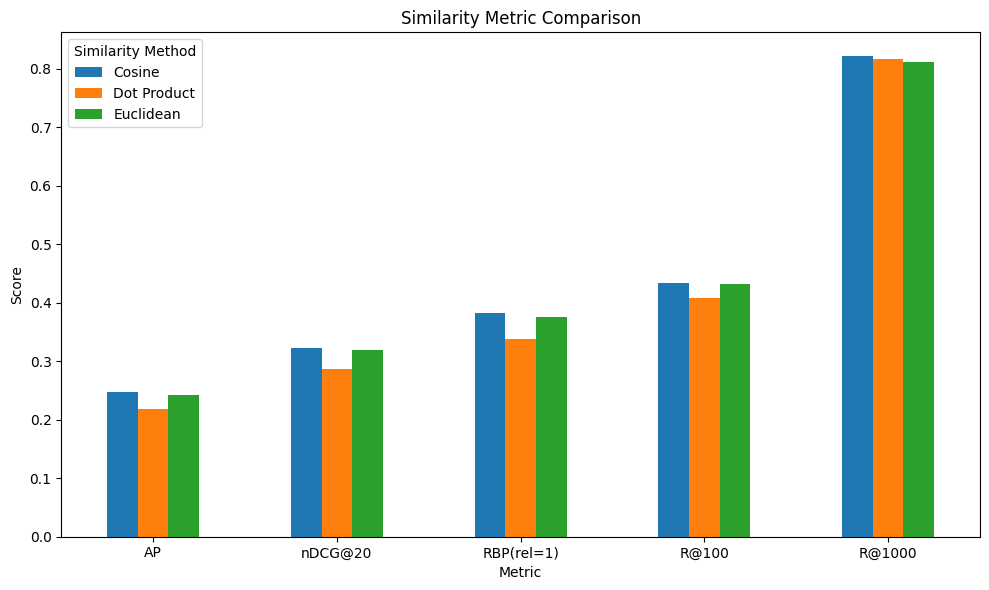

In [25]:
# Bar chart for comparison
comparison_df.set_index("Metric").plot(kind="bar", figsize=(10, 6))
plt.title("Similarity Metric Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Similarity Method")
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files

In [ ]:
files.download('title_embeddings.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>